In [44]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
from dm21cm.utils import load_h5_dict, save_h5_dict

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file(f"{WDIR}/matplotlibrc")

# Halo contribution v. mass

In [32]:
ps_m_data = load_h5_dict(f"./m_data.h5")

In [34]:
m_range = ps_m_data['m_range']
z_range = ps_m_data['z_range']
ann_rates = ps_m_data['annihilation_rates']
dNdM_ps = ps_m_data['dNdM']
dNdM_st = ps_m_data['dNdM_st']
print(m_range.shape)
print(z_range.shape)
print(ann_rates.shape)
print(dNdM_ps.shape)
print(dNdM_st.shape)

(4001,)
(51,)
(51, 4001)
(51, 4001)
(51, 4001)


In [46]:
box_len = 2 * u.Mpc
mbox = (cosmo.Om0 * cosmo.critical_density0 * box_len**3).to('M_sun').value

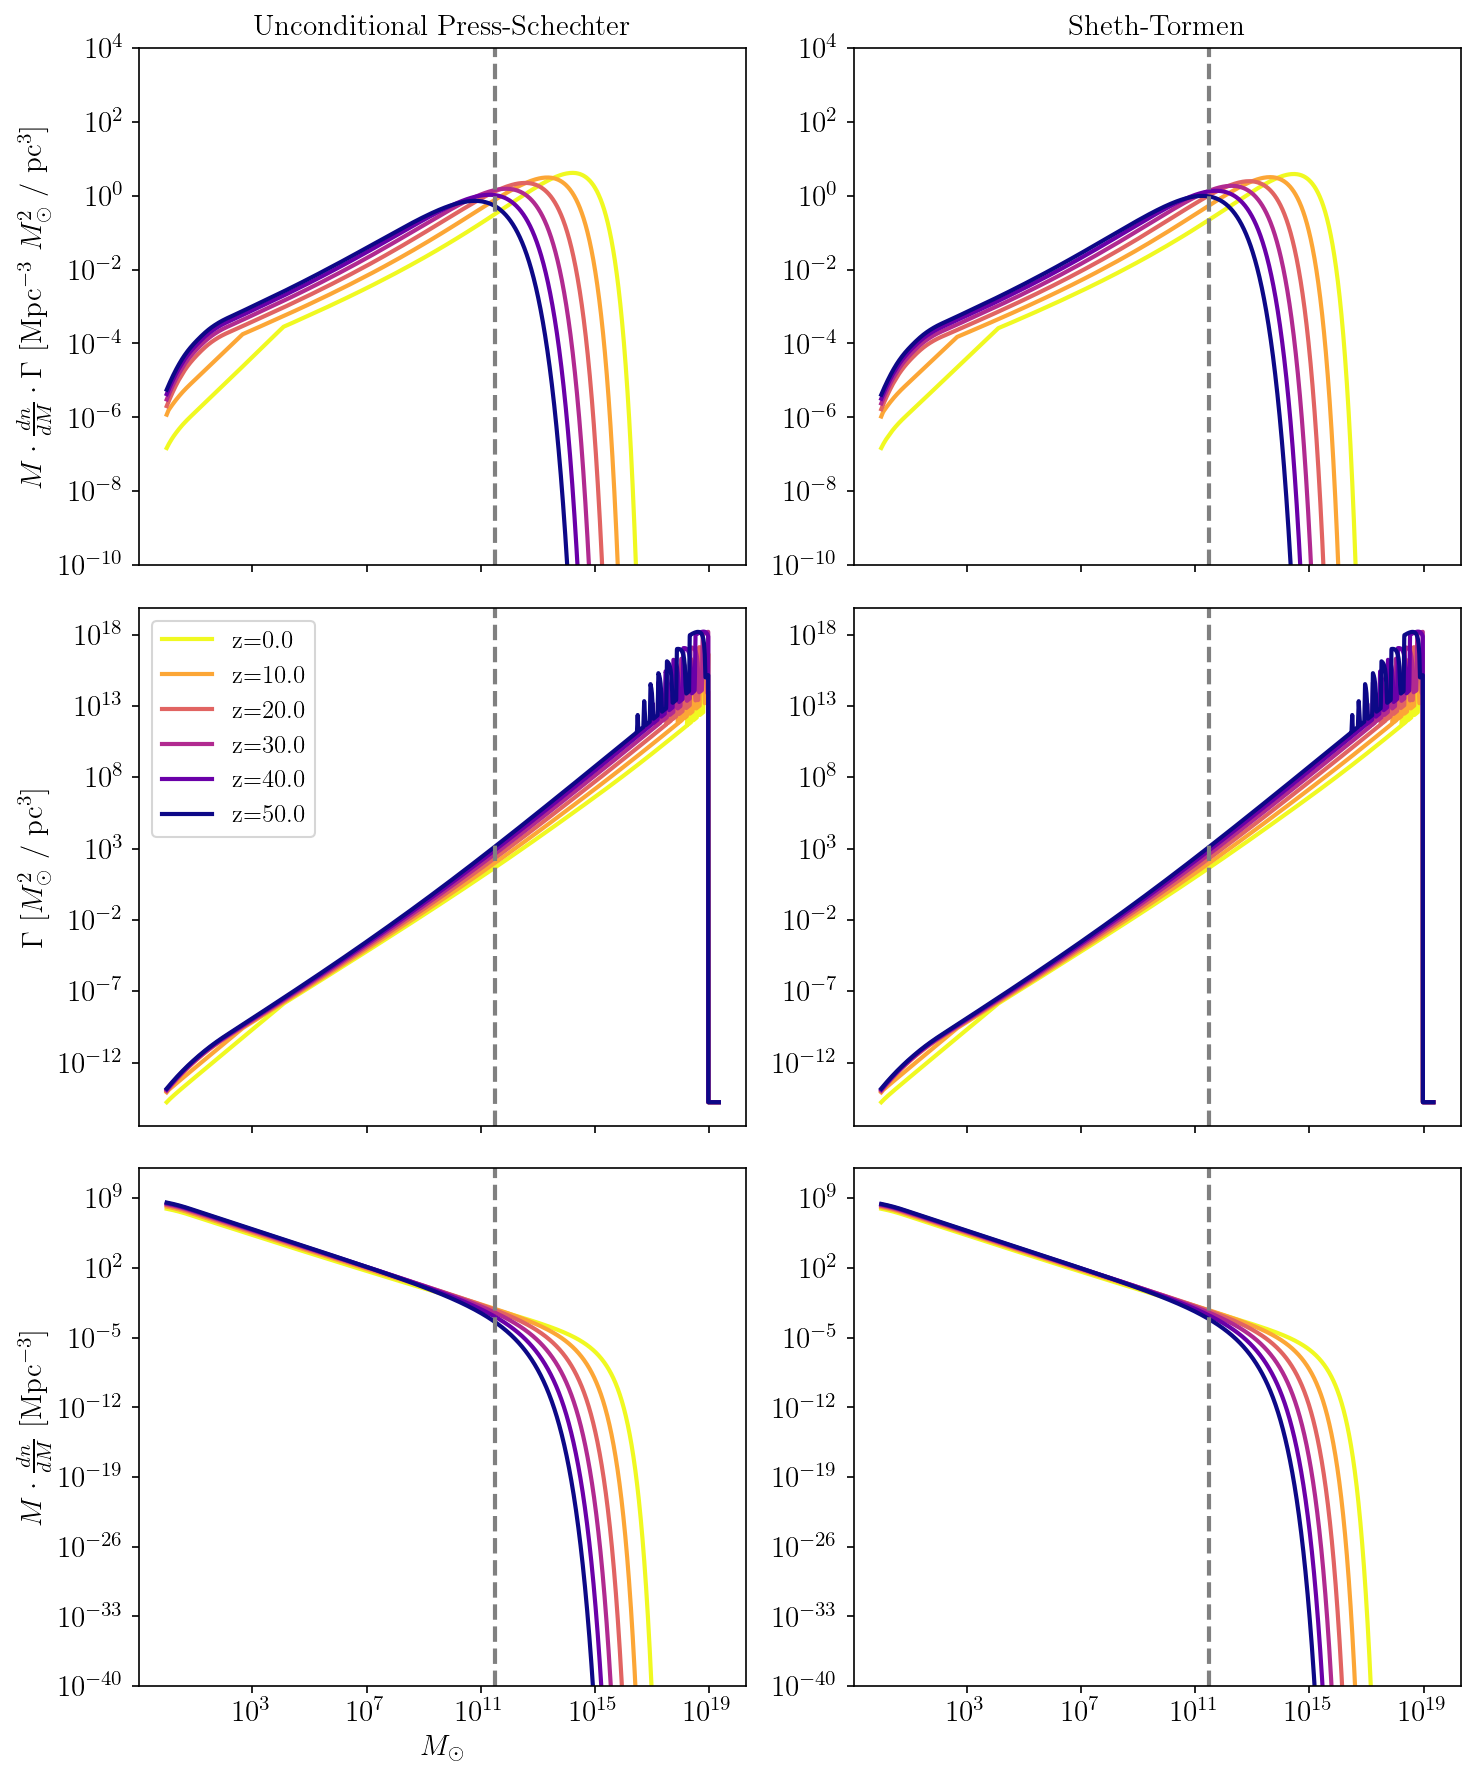

In [47]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12), sharex=True)

for i in range(3):
    for j in range(1, 2):
        axs[i, j].sharey(axs[i, 0])

def color_z(z):
    zmax = np.max(z_range)
    zmin = np.min(z_range)
    return mpl.colormaps['plasma'](1 - (z - zmin) / (zmax - zmin))

for i, z in enumerate(z_range[::10]):
    for j, dNdM in enumerate([dNdM_ps, dNdM_st]):
        axs[0,j].plot(m_range, m_range * dNdM[i] * ann_rates[i], label=f'z={z}', color=color_z(z))
        axs[1,j].plot(m_range, ann_rates[i], label=f'z={z}', color=color_z(z))
        axs[2,j].plot(m_range, m_range * dNdM[i], label=f'z={z}', color=color_z(z))

axs[0,0].set(xscale='log', yscale='log', ylim=(1e-10, 1e4))
axs[0,0].set(ylabel=r'$M\cdot\frac{dn}{dM}\cdot\Gamma$ [Mpc$^{-3}$ $M_\odot^2$ / pc$^3$]')
axs[1,0].set(xscale='log', yscale='log', ylim=(None, None))
axs[1,0].set(ylabel=r'$\Gamma$ [$M_\odot^2$ / pc$^3$]')
axs[2,0].set(xscale='log', yscale='log', ylim=(1e-40, 1e12))
axs[2,0].set(xlabel='$M_\odot$', ylabel=r'$M\cdot\frac{dn}{dM}$ [Mpc$^{-3}$]')
axs[1,0].legend()

for i in range(3):
    for j in range(2):
        axs[i,j].axvline(mbox, color='gray', ls='--')

axs[0,0].set(title='Unconditional Press-Schechter')
axs[0,1].set(title='Sheth-Tormen')

fig.tight_layout()

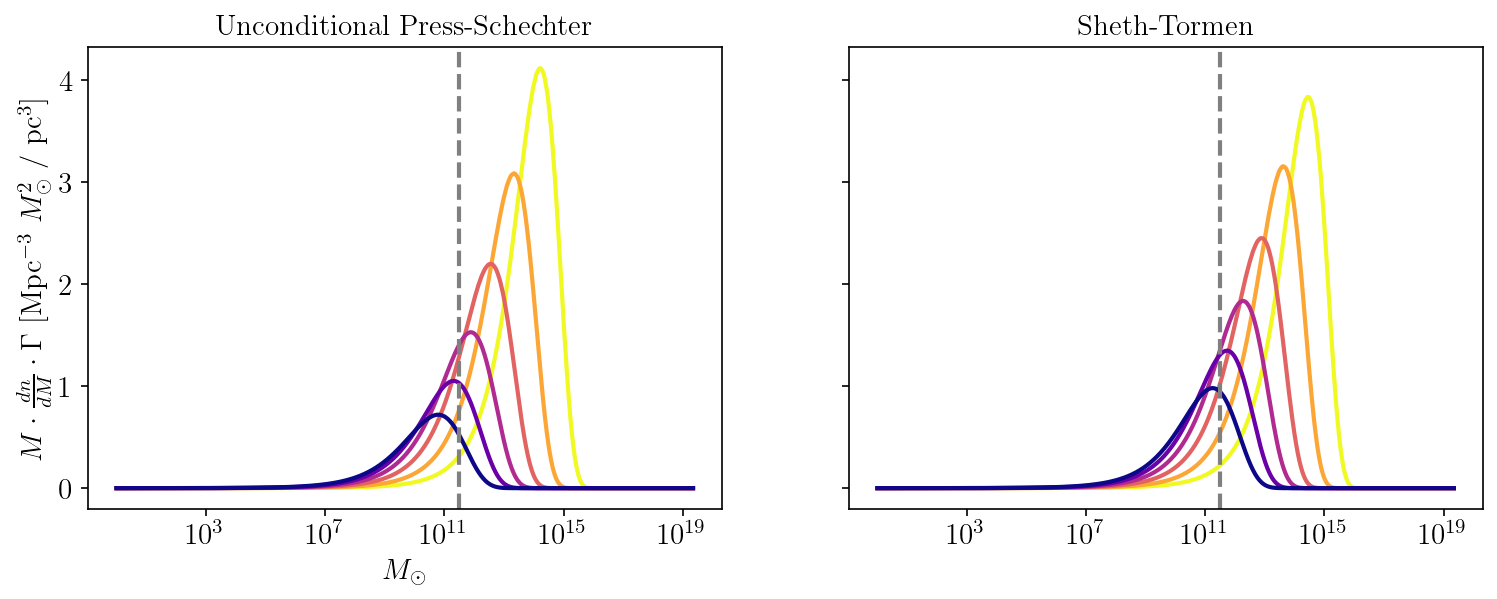

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

for i, z in enumerate(z_range[::10]):
    for j, dNdM in enumerate([dNdM_ps, dNdM_st]):
        axs[j].plot(m_range, m_range * dNdM[i] * ann_rates[i], label=f'z={z}', color=color_z(z))

axs[0].set(xscale='log')
axs[0].set(xlabel='$M_\odot$', ylabel=r'$M\cdot\frac{dn}{dM}\cdot\Gamma$ [Mpc$^{-3}$ $M_\odot^2$ / pc$^3$]')


for j in range(2):
    axs[j].axvline(mbox, color='gray', ls='--')

axs[0].set(title='Unconditional Press-Schechter')
axs[1].set(title='Sheth-Tormen');